In [40]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
input_ch = 3
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(trainset)

50000

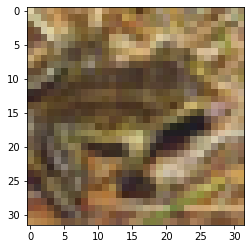

In [5]:
plt.imshow(trainset.data[228])

In [6]:
trainset, valset = random_split(trainset, [45000, 5000])
len(trainset), len(valset)

(45000, 5000)

In [7]:
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [31]:
class ResidualBlock(nn.Module):
    
    def __init__(self, input_ch, output_ch, identity_downsample=None, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_ch, output_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output_ch)
        self.conv2 = nn.Conv2d(output_ch, output_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(output_ch)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [32]:
class ResNet18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            ResidualBlock(out_channels, out_channels)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [33]:
model = ResNet18(3, 10)

In [34]:
#count trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

12555018

In [35]:
#move the model to the device
model.to(device)
next(model.parameters()).is_cuda

True

In [36]:
#define everything we need for training
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [ ]:
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="top1err")
x_epoch = []
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []


def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    ax1.plot(x_epoch, y_err['train'], 'bo-', label='train')
    ax1.plot(x_epoch, y_err['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig(os.path.join('./lossGraphs', 'train.jpg'))

In [37]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50):
    
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # Iterate over data
                
                #inputs = transforms.functional.resize(inputs, (112, 112))
                inputs = inputs.to(device)

                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train': # Backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if phase == 'val': # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)
                
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            y_loss[phase].append(epoch_loss)
            y_err[phase].append(1.0 - epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            if phase == 'val':
                draw_curve(epoch)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [38]:
model, _ = train_model(model, {"train": trainloader, "val": valloader}, criterion, optimizer, epochs)

Epoch 0/4
----------
train Loss: 1.2327 Acc: 0.5564
val Loss: 0.8286 Acc: 0.7062

Epoch 1/4
----------
train Loss: 0.7956 Acc: 0.7205
val Loss: 0.5952 Acc: 0.8012

Epoch 2/4
----------
train Loss: 0.5534 Acc: 0.8068
val Loss: 0.3734 Acc: 0.8736

Epoch 3/4
----------
train Loss: 0.3523 Acc: 0.8767
val Loss: 0.2312 Acc: 0.9232

Epoch 4/4
----------
train Loss: 0.2330 Acc: 0.9187
val Loss: 0.1695 Acc: 0.9452

Training complete in 3m 49s
Best val Acc: 0.945200


In [39]:
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="top1err")

def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    ax1.plot(x_epoch, y_err['train'], 'bo-', label='train')
    ax1.plot(x_epoch, y_err['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig(os.path.join('./lossGraphs', 'train.jpg'))


for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0.0

        count = 0
        # Iterate over data.
        for data in dataloaders[phase]:
            if count > 10:
                break

            count = count + 1
            # get a batch of inputs
            inputs, labels = data
            now_batch_size, c, h, w = inputs.shape
            if now_batch_size < batchsize:  # skip the last batch
                continue
            # print(inputs.shape)
            # wrap them in Variable, if gpu is used, we transform the data to cuda.
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # -------- forward --------
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            del inputs

            # -------- backward + optimize --------
            # only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * now_batch_size
            del loss
            running_corrects += float(torch.sum(preds == labels.data))

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        y_loss[phase].append(epoch_loss)
        y_err[phase].append(1.0 - epoch_acc)

        # deep copy the model
        if phase == 'val':
            draw_curve(epoch)

tensor([[[[ 0.2706,  0.2471,  0.2471,  ...,  0.1843,  0.1843,  0.1765],
          [ 0.3098,  0.2863,  0.2863,  ...,  0.2549,  0.2471,  0.2392],
          [ 0.3412,  0.3176,  0.3176,  ...,  0.3098,  0.3098,  0.3020],
          ...,
          [ 0.5529,  0.5451,  0.5451,  ...,  0.5451,  0.5373,  0.5294],
          [ 0.5451,  0.5294,  0.5373,  ...,  0.5373,  0.5216,  0.5137],
          [ 0.5451,  0.5294,  0.5373,  ...,  0.5373,  0.5216,  0.5137]],

         [[ 0.5059,  0.4824,  0.4824,  ...,  0.4667,  0.4667,  0.4588],
          [ 0.5451,  0.5216,  0.5216,  ...,  0.5137,  0.5137,  0.5059],
          [ 0.5765,  0.5529,  0.5529,  ...,  0.5529,  0.5529,  0.5451],
          ...,
          [ 0.7647,  0.7490,  0.7490,  ...,  0.7412,  0.7412,  0.7333],
          [ 0.7490,  0.7333,  0.7412,  ...,  0.7333,  0.7255,  0.7176],
          [ 0.7490,  0.7333,  0.7412,  ...,  0.7333,  0.7255,  0.7176]],

         [[ 0.5922,  0.5686,  0.5686,  ...,  0.5765,  0.5765,  0.5686],
          [ 0.6314,  0.6078,  